In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.metrics import classification_report_imbalanced

In [2]:
data = pd.read_csv('glass.data', names=['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type'])
data = data.drop(columns=['Id'])
data = data.drop(columns='Ca')
data.head()

,RI,Na,Mg,Al,Si,K,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,0.0,0.0,1


In [3]:
scaler = MinMaxScaler()
data_sc = scaler.fit_transform(data.drop(columns=['Type']))
print('Original dataset shape %s' % Counter(data.Type))
sm = SMOTETomek(random_state=42)
X_res, y_res = sm.fit_resample(data_sc, data.Type)
print('Resampled dataset shape %s' % Counter(y_res))
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state=17, train_size=0.66, shuffle=True)



Original dataset shape Counter({2: 76, 1: 70, 7: 29, 3: 17, 5: 13, 6: 9})
Resampled dataset shape Counter({5: 76, 6: 76, 7: 75, 3: 73, 1: 72, 2: 70})


In [4]:
clf = LogisticRegression(random_state=17, solver='saga', max_iter=10000).fit(X_train,y_train)
# clf = OneVsRestClassifier(LogisticRegression(random_state=42, solver='saga', max_iter=10000)).fit(X_train, y_train)
cv_sc = cross_val_score(clf, X_train, y_train, cv=4)
print(f"Cross-Validation Scores: {cv_sc}")

Cross-Validation Scores: [0.73972603 0.68493151 0.67123288 0.70833333]


In [5]:
clf.fit(X_train, y_train)

print(f'Train Score: {clf.score(X_train, y_train)}')
print(f'Test Score: {clf.score(X_test, y_test)}')

Train Score: 0.7697594501718213
Test Score: 0.7350993377483444


In [6]:
y_pred = clf.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.53      0.83      0.87      0.64      0.85      0.71        23
          2       0.57      0.17      0.98      0.27      0.41      0.16        23
          3       0.56      0.58      0.90      0.57      0.72      0.50        26
          5       0.79      1.00      0.95      0.88      0.98      0.96        22
          6       0.93      0.97      0.98      0.95      0.97      0.95        29
          7       1.00      0.82      1.00      0.90      0.91      0.81        28

avg / total       0.74      0.74      0.95      0.71      0.81      0.69       151



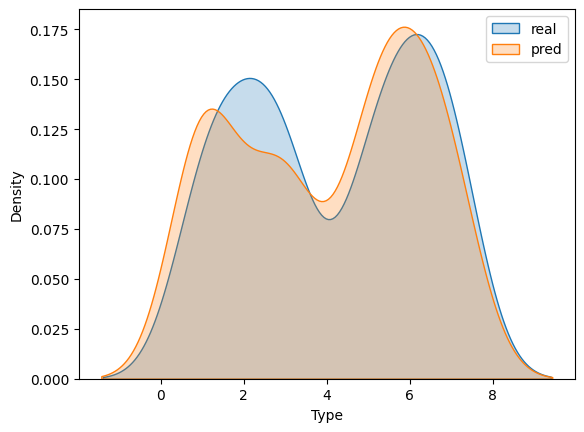

In [7]:
sns.kdeplot(y_test, fill=True, label='real')
sns.kdeplot(clf.predict(X_test), fill=True, label='pred')
plt.legend()

In [8]:
param_grid = {
    'penalty': ['elasticnet'],
    'l1_ratio': np.linspace(0.00001, 0.99, 50),
    'C':  np.linspace(0.0001, 10.0, 10),
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise')
grid_search.fit(X_train, y_train)
best_knn_reg = grid_search.best_estimator_
y_pred = best_knn_reg.predict(X_test)
print(best_knn_reg)
print(classification_report_imbalanced(y_test, y_pred))


LogisticRegression(C=7.777799999999999, l1_ratio=0.99, max_iter=10000,
                   penalty='elasticnet', random_state=17, solver='saga')
                   pre       rec       spe        f1       geo       iba       sup

          1       0.67      0.78      0.93      0.72      0.85      0.72        23
          2       0.80      0.70      0.97      0.74      0.82      0.66        23
          3       0.83      0.73      0.97      0.78      0.84      0.69        26
          5       0.88      1.00      0.98      0.94      0.99      0.98        22
          6       0.97      1.00      0.99      0.98      1.00      0.99        29
          7       0.96      0.89      0.99      0.93      0.94      0.88        28

avg / total       0.86      0.85      0.97      0.85      0.91      0.82       151



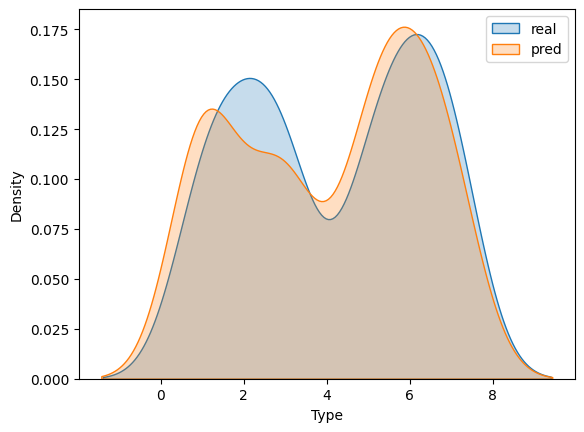

In [9]:
sns.kdeplot(y_test, fill=True, label='real')
sns.kdeplot(clf.predict(X_test), fill=True, label='pred')
plt.legend()

**SmoteTomek - комбінація овер та андерсемплінгу с використанням методів SMOTE i Tomek. Виявився кращим за звичайний оверсемплінг але все ще є кращі варіанти**